__Тема:__ Исследование различных групп пациентов на наличие болезни сердца или инсульта

# МАШИННОЕ ОБУЧЕНИЕ 
над этой частью работала Рыбьякова Лиза

# Imports & Settings

In [7]:
# imports
import numpy as np
import pandas as pd
import sklearn

# warnings disable
import warnings
warnings.filterwarnings("ignore")

# graphics settings:
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 6, 4
plt.rcParams['font.size'] = 12
sns.set_style('darkgrid')

# fix seed for reproducibility
SEED = 42

# Чтение данных

In [8]:
data_heart = pd.read_csv("data_heart.csv", index_col=['Unnamed: 0'])

In [9]:
print(f"В датасете {data_heart.shape[0]} объектов")
print(f"В датасете {data_heart.shape[1]} признаков")

В датасете 2635 объектов
В датасете 24 признаков


In [10]:
data_heart.head()

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,...,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,BMI_excess,healthy_lifestyle
215201,0.0,0.0,1.0,1.0,17.0,0.0,0.0,0.0,1.0,1.0,...,2.0,1.0,0.0,0.0,1.0,5.0,6.0,6.0,0.0,1.0
27524,0.0,1.0,1.0,1.0,33.0,1.0,0.0,2.0,0.0,1.0,...,5.0,5.0,10.0,1.0,1.0,4.0,2.0,6.0,1.0,0.0
149754,0.0,1.0,0.0,1.0,38.0,1.0,0.0,0.0,0.0,1.0,...,3.0,5.0,0.0,0.0,0.0,4.0,5.0,5.0,1.0,0.0
1436,0.0,1.0,0.0,1.0,29.0,0.0,0.0,0.0,1.0,0.0,...,2.0,0.0,0.0,0.0,1.0,12.0,4.0,6.0,1.0,0.0
206341,0.0,0.0,1.0,1.0,27.0,0.0,0.0,2.0,1.0,0.0,...,2.0,0.0,2.0,0.0,0.0,9.0,5.0,5.0,1.0,0.0


In [11]:
data_heart.columns

Index(['HeartDiseaseorAttack', 'HighBP', 'HighChol', 'CholCheck', 'BMI',
       'Smoker', 'Stroke', 'Diabetes', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income',
       'BMI_excess', 'healthy_lifestyle'],
      dtype='object')

Заметим, что все признаки в наших данных либо численные (различные показатели здоровья, например индекс массы тела), либо бинарные (то есть уже закодированные категориальные признаки), либо порядковые (например, возраст), поэтому нам не понадобится ничего кодировать. Можно рассматривать все признаки, как численные.

# Разделение выборки на Train / Val / Test

Помимо разделения данных на обучающую и тестовую выборки, будем также использовать валидационную выборку, по которой будут подбираться гиперпараметры. Поделим в соотношении 60% / 20% / 20%.

In [12]:
from sklearn.model_selection import train_test_split
df_train_heart, df_test_heart = train_test_split(data_heart, test_size=0.2, random_state=SEED)
df_train_heart, df_val_heart = train_test_split(df_train_heart, test_size=0.25, random_state=SEED)

In [13]:
target = "HeartDiseaseorAttack"
all_features_heart = df_train_heart.drop((target), axis=1).columns

In [14]:
X_train_heart, y_train_heart = df_train_heart.drop((target), axis=1), df_train_heart[target]
X_val_heart, y_val_heart = df_val_heart.drop((target), axis=1), df_val_heart[target]
X_test_heart, y_test_heart = df_test_heart.drop((target), axis=1), df_test_heart[target]

In [15]:
print(f"В тестовых данных людей с болезнью: {(y_test_heart == 1).sum()}, людей без болезни:  {(y_test_heart == 0).sum()}")

В тестовых данных людей с болезнью: 42, людей без болезни:  485


Датасет несбалансированный. Проверим, что соотношение людей с болезнью и без во всех выборках примерно одинаковое.

In [16]:
print("Отношение количества людей без болезни к количеству людей с болезнью:")
print(f"Train: {(y_train_heart == 0).sum() / (y_train_heart == 1).sum()}")
print(f"Val: {(y_val_heart == 0).sum() / (y_val_heart == 1).sum()}")
print(f"Test: {(y_test_heart == 0).sum() / (y_test_heart == 1).sum()}")

Отношение количества людей без болезни к количеству людей с болезнью:
Train: 12.512820512820513
Val: 11.255813953488373
Test: 11.547619047619047


# Baseline (KNN)

В качестве первого решения используем быстрый и простой случайный классификатор, которому вообще не требуется обучение: 
**K-nearest neighbors Classifier**. 

Заметим, что наши данные уже в закодированном формате, поэтому использовать кодирование не потребуется.

В качестве метрики accuracy не подойдет, так как данные несбалансированные. Будем мерить у всех моделей **roc_auc_score**.

Обучим KNN.

In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

model = KNeighborsClassifier().fit(X_train_heart, y_train_heart)
print(f"KNN: roc_auc_score, тестовая выборка: {roc_auc_score(y_test_heart, model.predict_proba(X_test_heart)[:, 1])}")

KNN: roc_auc_score, тестовая выборка: 0.692120765832106


Отнормируем численные признаки.

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

def make_pipeline(model):
    numeric_transformer = Pipeline(
        steps=[("scaler", StandardScaler())]
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, all_features_heart),
        ]
    )

    return Pipeline(
        steps=[("preprocessor", preprocessor), ("classifier", model)]
    )
    
model = make_pipeline(KNeighborsClassifier()).fit(X_train_heart, y_train_heart)
print(f"KNeighborsClassifier + scaler: roc_auc_score, тестовая выборка: {roc_auc_score(y_test_heart, model.predict_proba(X_test_heart)[:, 1])}")

KNeighborsClassifier + scaler: roc_auc_score, тестовая выборка: 0.6824251350024546


 После нормирования качество модели чуть ухудшилось. Это может быть связано с маленьким количеством данных. Случайный классификатор работает лучше без нормировки данных.

# Линейные модели

Обучим логистическую регрессию, чтоб посмотреть как хорошо наша модель предсказывает целевую переменную, то есть саму болезнь сердца.

In [19]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression().fit(X_train_heart, y_train_heart)
print(f"LogisticRegression: roc_auc_score, тестовая выборка: {roc_auc_score(y_test_heart, model.predict_proba(X_test_heart)[:, 1])}")

LogisticRegression: roc_auc_score, тестовая выборка: 0.8277859597447227


Протестируем модель с нормализованными весами.

In [20]:
from sklearn.linear_model import LogisticRegression

model = make_pipeline(LogisticRegression()).fit(X_train_heart, y_train_heart)
print(f"LogisticRegression: roc_auc_score, тестовая выборка: {roc_auc_score(y_test_heart, model.predict_proba(X_test_heart)[:, 1])}")

LogisticRegression: roc_auc_score, тестовая выборка: 0.8361315660284732


Качество немного выросло.

Подберем гиперпараметры. Будем использовать GridSearch: итерироваться по всем вариантам параметрам и максимизировать roc_auc_score. Так как мы выделили отдельную валидационную выборку, будем использовать не GridSearch из sklearn (он делает кросс-валидацию), а в ручную итерироваться по параметрам.

In [159]:
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm

grid = {
    'C' : np.logspace(-3, 3, 20),
    'penalty' : ['l2', 'none'],
    'solver':['newton-cg','sag','saga','lbfgs']
}

best_score = 0.5
best_model = LogisticRegression()
best_params = {}

for params in tqdm(ParameterGrid(grid)):
    model = make_pipeline(LogisticRegression(**params)).fit(X_train_heart, y_train_heart)
    score = roc_auc_score(y_val_heart, model.predict_proba(X_val_heart)[:, 1]) 
    if score > best_score:
        best_score = score
        best_params = params
        best_model = model
print(roc_auc_score(y_test_heart, model.predict_proba(X_test_heart)[:, 1]) )

100%|█████████████████████████████████████████| 160/160 [00:02<00:00, 78.13it/s]

0.8363770250368188


Качество еще немного улучшилось. Это говорит нам о том, что подбор гиперпараметров помог нам увеличить эффективность модели.

Построим для нашего классификатора ROC-кривую, которая отображает его качество на различных порогах.

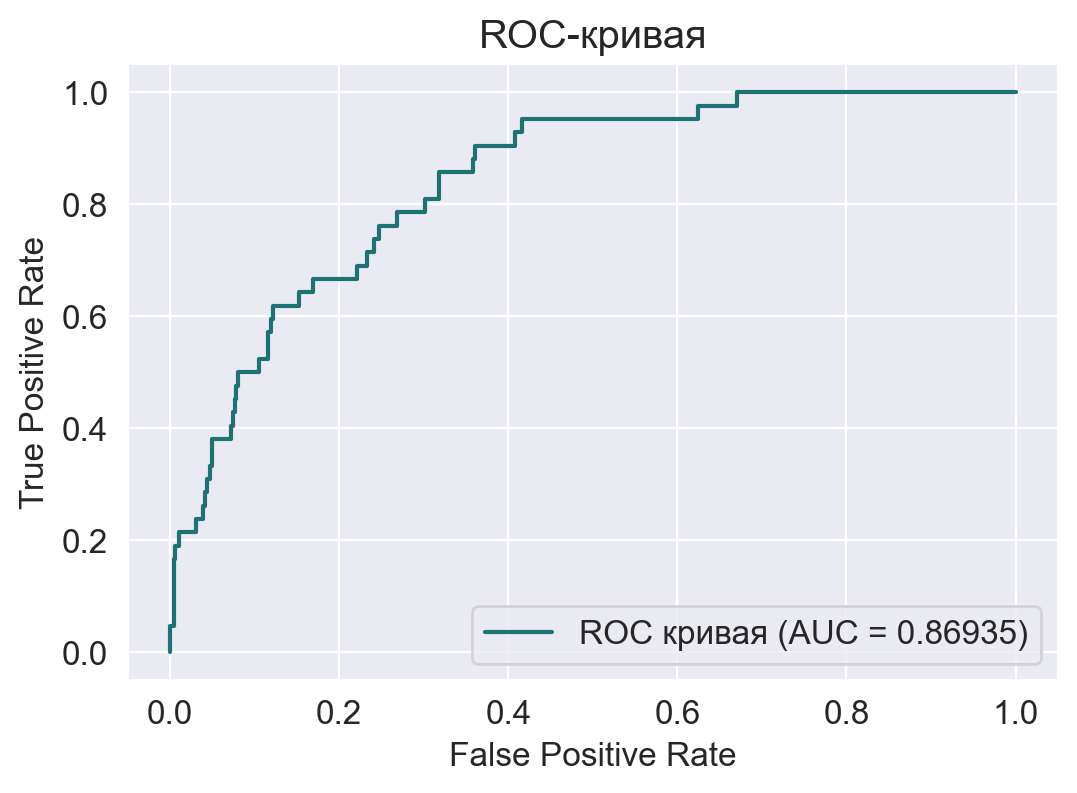

In [165]:
from sklearn.metrics import roc_curve

preds = best_model.predict_proba(X_test_heart)[:, 1]
fpr, tpr, treshold = roc_curve(y_test_heart, preds)

plt.plot(fpr, tpr, color='#1D7373',
         label='ROC кривая (AUC = %0.5f)' % best_score)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend()
plt.show()

Подбирая гиперпараметры, мы оптимизировали площадь под ROC-кривой, один из базовых показателей классификации. Модель работает значительно лучше, чем случайный классификатор. В качестве альтернативного показателя, мы могли бы оптимизировать площадь под PR-кривой. Эти метрики оценивают качество работы классификатора, перебирая различные пороги классификации. Также, если бы нам были известны требуемые свойства модели, мы бы могли перебирать порог самостоятельно. Например, в случае precision и recall precision показывает, сколько наша модель сделала бы ложных предсказаний об инсульте, а recall показала бы, сколько всего людей с инсультов из всех модель бы смогла найти. Очевидно, что лучше сделать ложное предсказание об инсульте, когда его нет, чем пропустить настоящий случай инсульта. Поэтому, можно зафиксировать какое-либо значение precision, и оптимизировать recall модели с precision => этого значения. В нашем же случае мы просто оптмизировали некоторое среднее значение.

# Анасамблевые методы

Используем лес, случайный классификатор, алгоритм обучения с учителем,чтобы улучшить наш скор. Также Random Forest помогает нам оценить важность каждого признака для классификации объектов

In [21]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier().fit(X_train_heart, y_train_heart)
print(f"RandomForest: roc_auc_score, тестовая выборка: {roc_auc_score(y_test_heart, model.predict_proba(X_test_heart)[:, 1])}")

RandomForest: roc_auc_score, тестовая выборка: 0.8109720176730486


In [162]:
grid = {
    'n_estimators' : [100, 200, 400, 800],
    'max_depth' : [5, 20, None],
    'min_samples_split' : [2, 8, 32],
    'min_samples_leaf' : [1, 4, 16] 
}
best_score = 0.5
best_model = RandomForestClassifier()
best_params = {}

for params in tqdm(ParameterGrid(grid)):
    model = make_pipeline(RandomForestClassifier(**params)).fit(X_train_heart, y_train_heart)
    score = roc_auc_score(y_val_heart, model.predict_proba(X_val_heart)[:, 1]) 
    if score > best_score:
        best_score = score
        best_params = params
        best_model = model
print(roc_auc_score(y_test_heart, model.predict_proba(X_test_heart)[:, 1]) )
print(best_params)

100%|█████████████████████████████████████████| 108/108 [00:41<00:00,  2.59it/s]

0.8408443789887089
{'max_depth': None, 'min_samples_leaf': 16, 'min_samples_split': 32, 'n_estimators': 200}


Лес с подбором параметров показывает наилучший roc_auc

Посмотрим на самые важные признаки, которые отобрал случайный лес.

In [166]:
# Чем позже признак, тем важнее он
df_train.drop((target), axis=1).columns[best_model[1].feature_importances_.argsort()]

Index(['AnyHealthcare', 'CholCheck', 'HvyAlcoholConsump', 'healthy_lifestyle',
       'NoDocbcCost', 'BMI_excess', 'Veggies', 'PhysActivity', 'Stroke',
       'MentHlth', 'Fruits', 'Sex', 'Education', 'Smoker', 'PhysHlth',
       'Income', 'BMI', 'DiffWalk', 'HighChol', 'Diabetes', 'HighBP',
       'GenHlth', 'Age'],
      dtype='object')

Видим, что возраст это самый важный признак. Это согласуется с логикой (чем старее человек, тем вероятнее болезнь). 

In [167]:
best_model[1].feature_importances_

array([0.10444115, 0.07611306, 0.00037234, 0.05981591, 0.02833595,
       0.015492  , 0.10186363, 0.01181034, 0.01741031, 0.00848401,
       0.00058314, 0.0003146 , 0.00588325, 0.12162258, 0.01725922,
       0.04318173, 0.06784931, 0.01885127, 0.2180349 , 0.02423206,
       0.04668604, 0.00612245, 0.00524078])

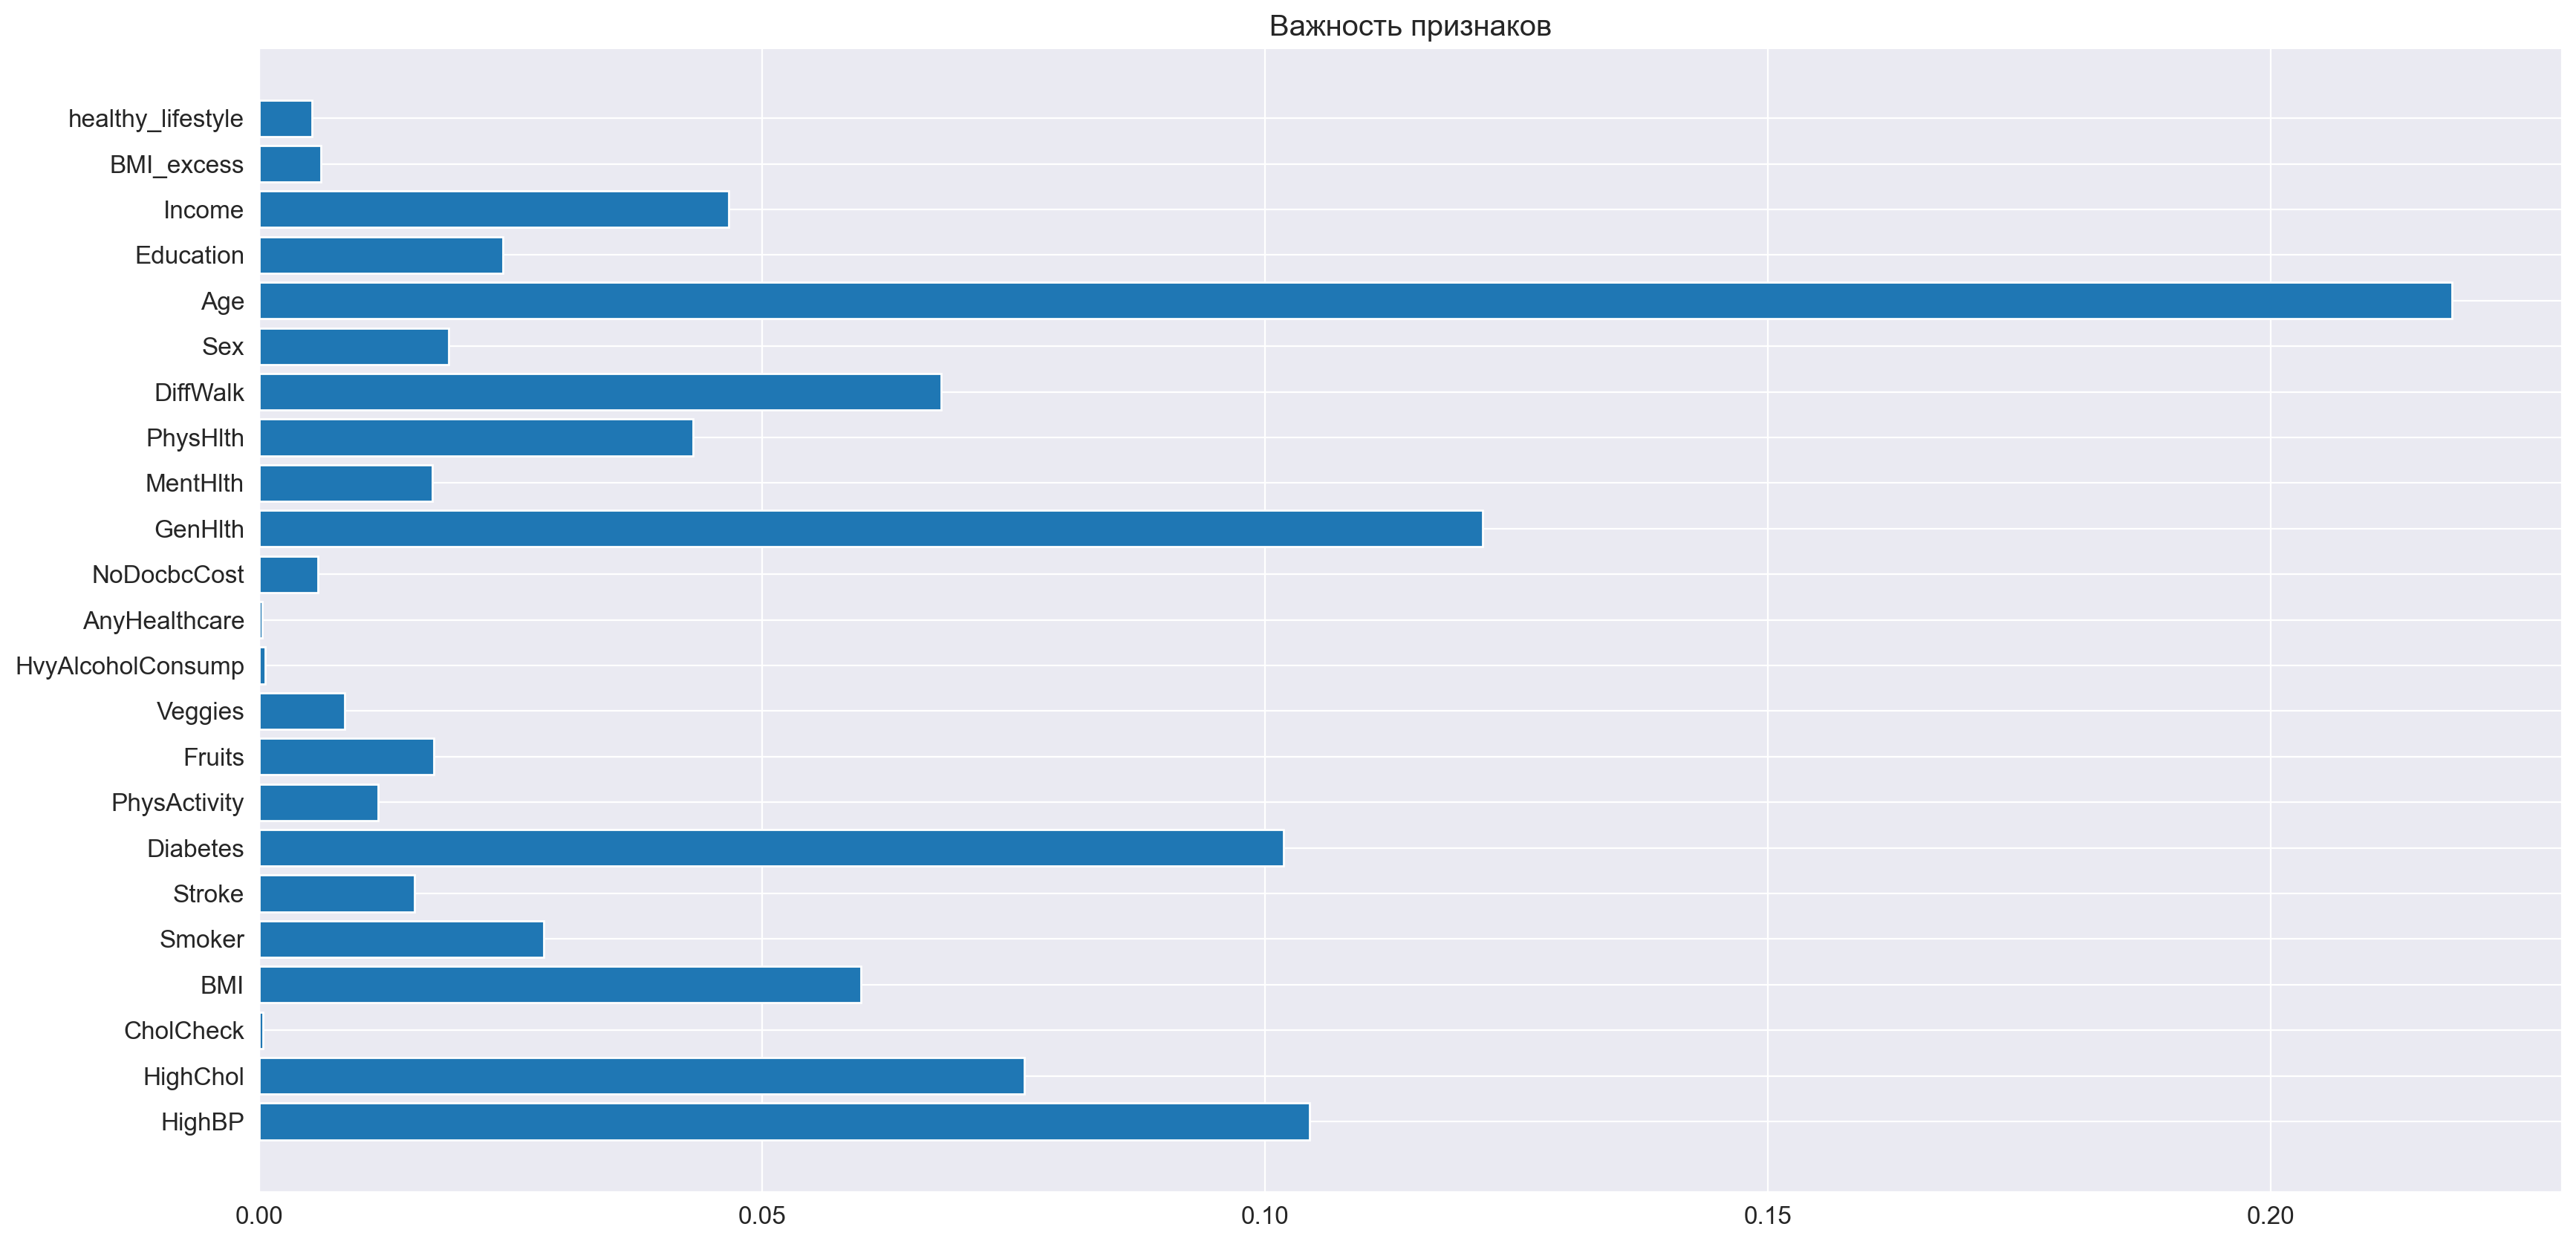

In [168]:
plt.figure(figsize=(20, 10))
plt.title("Важность признаков")
plt.barh(df_train.drop((target), axis=1).columns, best_model[1].feature_importances_, capsize=1,)
plt.show()

Обучим градиентный бустинг.

Так как в отличие от Random Forest, Gradient boosting - не усредненное моделей, в нем каждая новая модель уточняется предыдущей.(сумма результатов последовательных decision trees для решения новой модели). 
Используем его, надеясь, что скор улучшится.

In [172]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier().fit(X_train_heart, y_train_heart)
print(f"GradientBoosting: roc_auc_score, тестовая выборка: {roc_auc_score(y_test_heart, model.predict_proba(X_test_heart)[:, 1])}")

GradientBoosting: roc_auc_score, тестовая выборка: 0.8295041728031418


In [180]:
grid = {
    'n_estimators' : [40, 80, 160],
    'max_depth' : [1, 2, 4, 8],
    'learning_rate' : [0.01, 0.1,1] 
}
best_score = 0.5
best_model = GradientBoostingClassifier()
best_params = {}

for params in tqdm(ParameterGrid(grid)):
    model = make_pipeline(GradientBoostingClassifier(**params)).fit(X_train_heart, y_train_heart)
    score = roc_auc_score(y_val_heart, model.predict_proba(X_val_heart)[:, 1]) 
    if score > best_score:
        best_score = score
        best_params = params
        best_model = model
print(roc_auc_score(y_test_heart, model.predict_proba(X_test_heart)[:, 1]) )
print(best_params)

100%|███████████████████████████████████████████| 36/36 [00:06<00:00,  5.64it/s]

0.7827196858124693
{'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 160}


Качество от подбора гиперпараметров значительно увеличивается,если мы смотрим на регрессию или лес, однако бустинг работает хуже. Вероятно, так получается по причине небольшого количества данных.

Лес с подобранными параметрами оказывается лучшим по сравнению с регрессией и бустингом.

#  Чтение данных

In [26]:
data_stroke = pd.read_csv("data_stroke.csv", index_col=['Unnamed: 0'])
data_stroke

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Male,ever_married_Yes,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,BMI_excess,glucose_level_normal
2411,60.0,0,0,87.86,29.0,0,1,1,1,0,0,0,1,0,0,1.0,1.0
2109,47.0,0,0,131.43,24.3,0,0,1,1,0,0,1,0,1,0,0.0,0.0
3906,19.0,0,0,56.33,29.4,0,1,0,1,0,0,0,0,0,0,1.0,0.0
1138,53.0,0,0,78.73,23.3,0,1,1,0,0,0,0,0,1,0,0.0,0.0
3714,41.0,0,0,92.14,29.6,0,0,1,1,0,0,1,1,0,0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1617,45.0,0,0,176.48,24.0,0,0,1,1,0,0,0,1,0,0,0.0,0.0
3540,50.0,0,1,68.09,35.5,0,0,1,0,0,0,1,0,0,1,1.0,0.0
4273,60.0,0,0,200.25,33.1,0,1,1,0,0,0,0,0,1,0,1.0,0.0
1890,57.0,0,0,84.18,35.5,0,0,1,1,0,0,0,0,1,0,1.0,1.0


In [27]:
print(f"В датасете {data_stroke.shape[0]} объектов")
print(f"В датасете {data_stroke.shape[1]} признаков")

В датасете 2727 объектов
В датасете 17 признаков


In [28]:
data_stroke.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Male,ever_married_Yes,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,BMI_excess,glucose_level_normal
2411,60.0,0,0,87.86,29.0,0,1,1,1,0,0,0,1,0,0,1.0,1.0
2109,47.0,0,0,131.43,24.3,0,0,1,1,0,0,1,0,1,0,0.0,0.0
3906,19.0,0,0,56.33,29.4,0,1,0,1,0,0,0,0,0,0,1.0,0.0
1138,53.0,0,0,78.73,23.3,0,1,1,0,0,0,0,0,1,0,0.0,0.0
3714,41.0,0,0,92.14,29.6,0,0,1,1,0,0,1,1,0,0,1.0,1.0


In [29]:
data_stroke.columns

Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi',
       'stroke', 'gender_Male', 'ever_married_Yes', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children', 'Residence_type_Urban',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes', 'BMI_excess', 'glucose_level_normal'],
      dtype='object')

Заметим, что все признаки в наших данных либо численные (различные показатели здоровья, например индекс массы тела), либо бинарные (то есть уже закодированные категориальные признаки), либо порядковые (например, возраст), поэтому нам не понадобится ничего кодировать. Можно рассматривать все признаки, как численные.

# Разделение выборки на Train / Val / Test

Помимо разделения данных на обучающую и тестовую выборки, будем также использовать валидационную выборку, по которой будут подбираться гиперпараметры. Поделим в соотношении 60% / 20% / 20%.

In [30]:
from sklearn.model_selection import train_test_split
df_train_stroke, df_test_stroke = train_test_split(data_stroke, test_size=0.2, random_state=SEED)
df_train_stroke, df_val_stroke = train_test_split(df_train_stroke, test_size=0.25, random_state=SEED)

In [31]:
target = "stroke"
all_features_stroke = df_train_stroke.drop((target), axis=1).columns

In [32]:
X_train_stroke, y_train_stroke = df_train_stroke.drop((target), axis=1), df_train_stroke[target]
X_val_stroke, y_val_stroke = df_val_stroke.drop((target), axis=1), df_val_stroke[target]
X_test_stroke, y_test_stroke = df_test_stroke.drop((target), axis=1), df_test_stroke[target]

In [33]:
print(f"В тестовых данных людей с болезнью: {(y_test_stroke == 1).sum()}, людей без болезни:  {(y_test_stroke == 0).sum()}")

В тестовых данных людей с болезнью: 17, людей без болезни:  529


Датасет несбалансированный. Проверим, что соотношение людей с болезнью и без во всех выборках примерно одинаковое.

In [34]:
print("Отношение количества людей без болезни к количеству людей с болезнью")
print(f"Train: {(y_train_stroke == 0).sum() / (y_train_stroke == 1).sum()}")
print(f"Val: {(y_val_stroke == 0).sum() / (y_val_stroke == 1).sum()}")
print(f"Test: {(y_test_stroke == 0).sum() / (y_test_stroke == 1).sum()}")

Отношение количества людей без болезни к количеству людей с болезнью
Train: 21.708333333333332
Val: 27.736842105263158
Test: 31.11764705882353


# Baseline (KNN)

В качестве первого решения используем быстрый и простой классификатор, которому вообще не требуется обучение: K-nearest neighbors Classifier.

Заметим, что наши данные уже в закодированном формате, поэтому использовать кодирование не потребуется.
В качестве метрики accuracy не подойдет, так как данные несбалансированные. Будем мерить у всех моделей roc_auc_score.

Обучим KNN.

In [35]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

model = KNeighborsClassifier().fit(X_train_stroke, y_train_stroke)
print(f"KNN: roc_auc_score, тестовая выборка: {roc_auc_score(y_test_stroke, model.predict_proba(X_test_stroke)[:, 1])}")

KNN: roc_auc_score, тестовая выборка: 0.719281663516068


Отнормируем численные признаки.

In [36]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

def make_pipeline(model):
    numeric_transformer = Pipeline(
        steps=[("scaler", StandardScaler())]
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, all_features_stroke),
        ]
    )

    return Pipeline(
        steps=[("preprocessor", preprocessor), ("classifier", model)]
    )
    
model = make_pipeline(KNeighborsClassifier()).fit(X_train_stroke, y_train_stroke)
print(f"KNeighborsClassifier + scaler: roc_auc_score, тестовая выборка: {roc_auc_score(y_test_stroke, model.predict_proba(X_test_stroke)[:, 1])}")

KNeighborsClassifier + scaler: roc_auc_score, тестовая выборка: 0.5054486823084622


После нормирования качество модели чуть ухудшилось. Это может быть связано с маленьким количеством данных. 

Случайный классификатор работает лучше без нормировки данных.


# Линейные модели

Обучим логистическую регрессию, чтоб посмотреть как хорошо наша модель предсказывает целевую переменную, то есть сам инсульт.

In [37]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression().fit(X_train_stroke, y_train_stroke)
print(f"LogisticRegression: roc_auc_score, тестовая выборка: {roc_auc_score(y_test_stroke, model.predict_proba(X_test_stroke)[:, 1])}")

LogisticRegression: roc_auc_score, тестовая выборка: 0.7796063605026131


Протестируем модель с нормализованными весами.

In [38]:
from sklearn.linear_model import LogisticRegression

model = make_pipeline(LogisticRegression()).fit(X_train_stroke, y_train_stroke)
print(f"LogisticRegression: roc_auc_score, тестовая выборка: {roc_auc_score(y_test_stroke, model.predict_proba(X_test_stroke)[:, 1])}")

LogisticRegression: roc_auc_score, тестовая выборка: 0.7996219281663516


Качество немного выросло.

Подберем гиперпараметры. Будем использовать GridSearch: итерироваться по всем вариантам параметрам и максимизировать roc_auc_score. Так как мы выделили отдельную валидационную выборку, будем использовать не GridSearch из sklearn (он делает кросс-валидацию), а в ручную итерироваться по параметрам.

In [39]:
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm

grid = {
    'C' : np.logspace(-3, 3, 20),
    'penalty' : ['l2', 'none'],
    'solver':['newton-cg','sag','saga','lbfgs']
}

best_score = 0.5
best_model = LogisticRegression()
best_params = {}

for params in tqdm(ParameterGrid(grid)):
    model = make_pipeline(LogisticRegression(**params)).fit(X_train_stroke, y_train_stroke)
    score = roc_auc_score(y_val_stroke, model.predict_proba(X_val_stroke)[:, 1]) 
    if score > best_score:
        best_score = score
        best_params = params
        best_model = model
print(roc_auc_score(y_test_stroke, model.predict_proba(X_test_stroke)[:, 1]) )

100%|█████████████████████████████████████████| 160/160 [00:03<00:00, 51.59it/s]

0.7997331257644835


Качество еще немного улучшилось. Это говорит нам о том, что подбор гиперпараметров помог нам увеличить эффективность модели.


Построим для нашего классификатора ROC-кривую, которая отображает его качество на различных порогах.

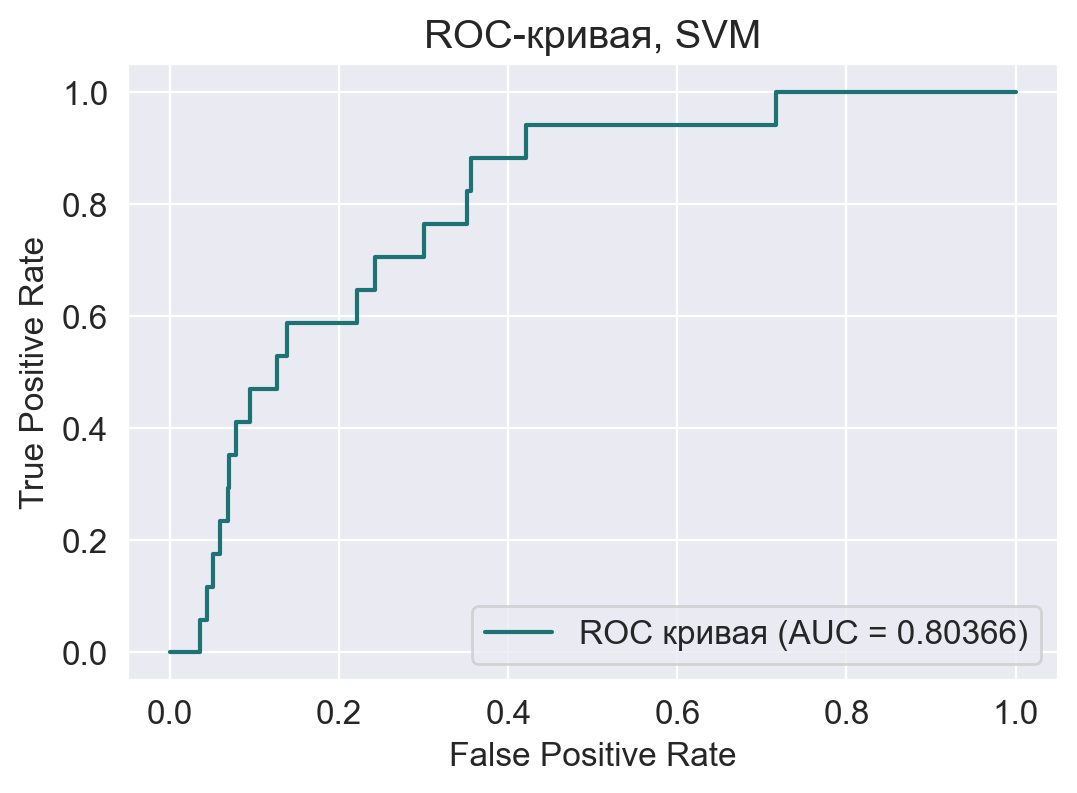

In [40]:
from sklearn.metrics import roc_curve

preds = best_model.predict_proba(X_test_stroke)[:, 1]
fpr, tpr, treshold = roc_curve(y_test_stroke, preds)

plt.plot(fpr, tpr, color='#1D7373',
         label='ROC кривая (AUC = %0.5f)' % best_score)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая, SVM')
plt.legend()
plt.show()

Подбирая гиперпараметры, мы оптимизировали площадь под ROC-кривой, один из базовых показателей классификации. Модель работает значительно лучше, чем случайный классификатор. В качестве альтернативного показателя, мы могли бы оптимизировать площадь под PR-кривой. Эти метрики оценивают качество работы классификатора, перебирая различные пороги классификации. Также, если бы нам были известны требуемые свойства модели, мы бы могли перебирать порог самостоятельно. Например, в случае precision и recall precision показывает, сколько наша модель сделала бы ложных предсказаний об инсульте, а recall показала бы, сколько всего людей с инсультов из всех модель бы смогла найти. Очевидно, что лучше сделать ложное предсказание об инсульте, когда его нет, чем пропустить настоящий случай инсульта. Поэтому, можно зафиксировать какое-либо значение precision, и оптимизировать recall модели с precision => этого значения. В нашем же случае мы просто оптмизировали некоторое среднее значение.

# Анасамблевые методы

Используем лес, случайный классификатор, алгоритм обучения с учителем,чтобы улучшить наш скор. 
Также Random Forest помогает нам оценить важность каждого признака для классификации объектов

In [41]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier().fit(X_train_stroke, y_train_stroke)
print(f"RandomForest: roc_auc_score, тестовая выборка: {roc_auc_score(y_test_stroke, model.predict_proba(X_test_stroke)[:, 1])}")

RandomForest: roc_auc_score, тестовая выборка: 0.7344045368620038


In [42]:
grid = {
    'n_estimators' : [100, 200, 400, 800],
    'max_depth' : [5, 20, None],
    'min_samples_split' : [2, 8, 32],
    'min_samples_leaf' : [1, 4, 16] 
}
best_score = 0.5
best_model = RandomForestClassifier()
best_params = {}

for params in tqdm(ParameterGrid(grid)):
    model = make_pipeline(RandomForestClassifier(**params)).fit(X_train_stroke, y_train_stroke)
    score = roc_auc_score(y_val_stroke, model.predict_proba(X_val_stroke)[:, 1]) 
    if score > best_score:
        best_score = score
        best_params = params
        best_model = model
print(roc_auc_score(y_test_stroke, model.predict_proba(X_test_stroke)[:, 1]) )
print(best_params)

100%|█████████████████████████████████████████| 108/108 [00:47<00:00,  2.28it/s]

0.7887245635494272
{'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}


Лес с подбором параметров показывает наилучший roc_auc

Посмотрим на самые важные признаки, которые отобрал случайный лес.

In [247]:
# Чем позже признак, тем важнее он
df_train_stroke.drop((target), axis=1).columns[best_model[1].feature_importances_.argsort()]

Index(['work_type_children', 'smoking_status_smokes',
       'smoking_status_formerly smoked', 'work_type_Self-employed',
       'work_type_Private', 'BMI_excess', 'ever_married_Yes',
       'Residence_type_Urban', 'gender_Male', 'smoking_status_never smoked',
       'glucose_level_normal', 'heart_disease', 'hypertension', 'bmi',
       'avg_glucose_level', 'age'],
      dtype='object')

Видим, что возраст это самый важный признак. 
Это согласуется с логикой (чем старее человек, тем вероятнее болезнь). 

Более того, как и в первом дата сете, на болезнь влияет прежде всего **возраст**.

In [248]:
best_model[1].feature_importances_

array([0.45556413, 0.07774065, 0.0309775 , 0.16688245, 0.10597104,
       0.0227107 , 0.01775512, 0.01183087, 0.00988979, 0.00477908,
       0.01912498, 0.00894205, 0.02418639, 0.005469  , 0.01216913,
       0.02600713])

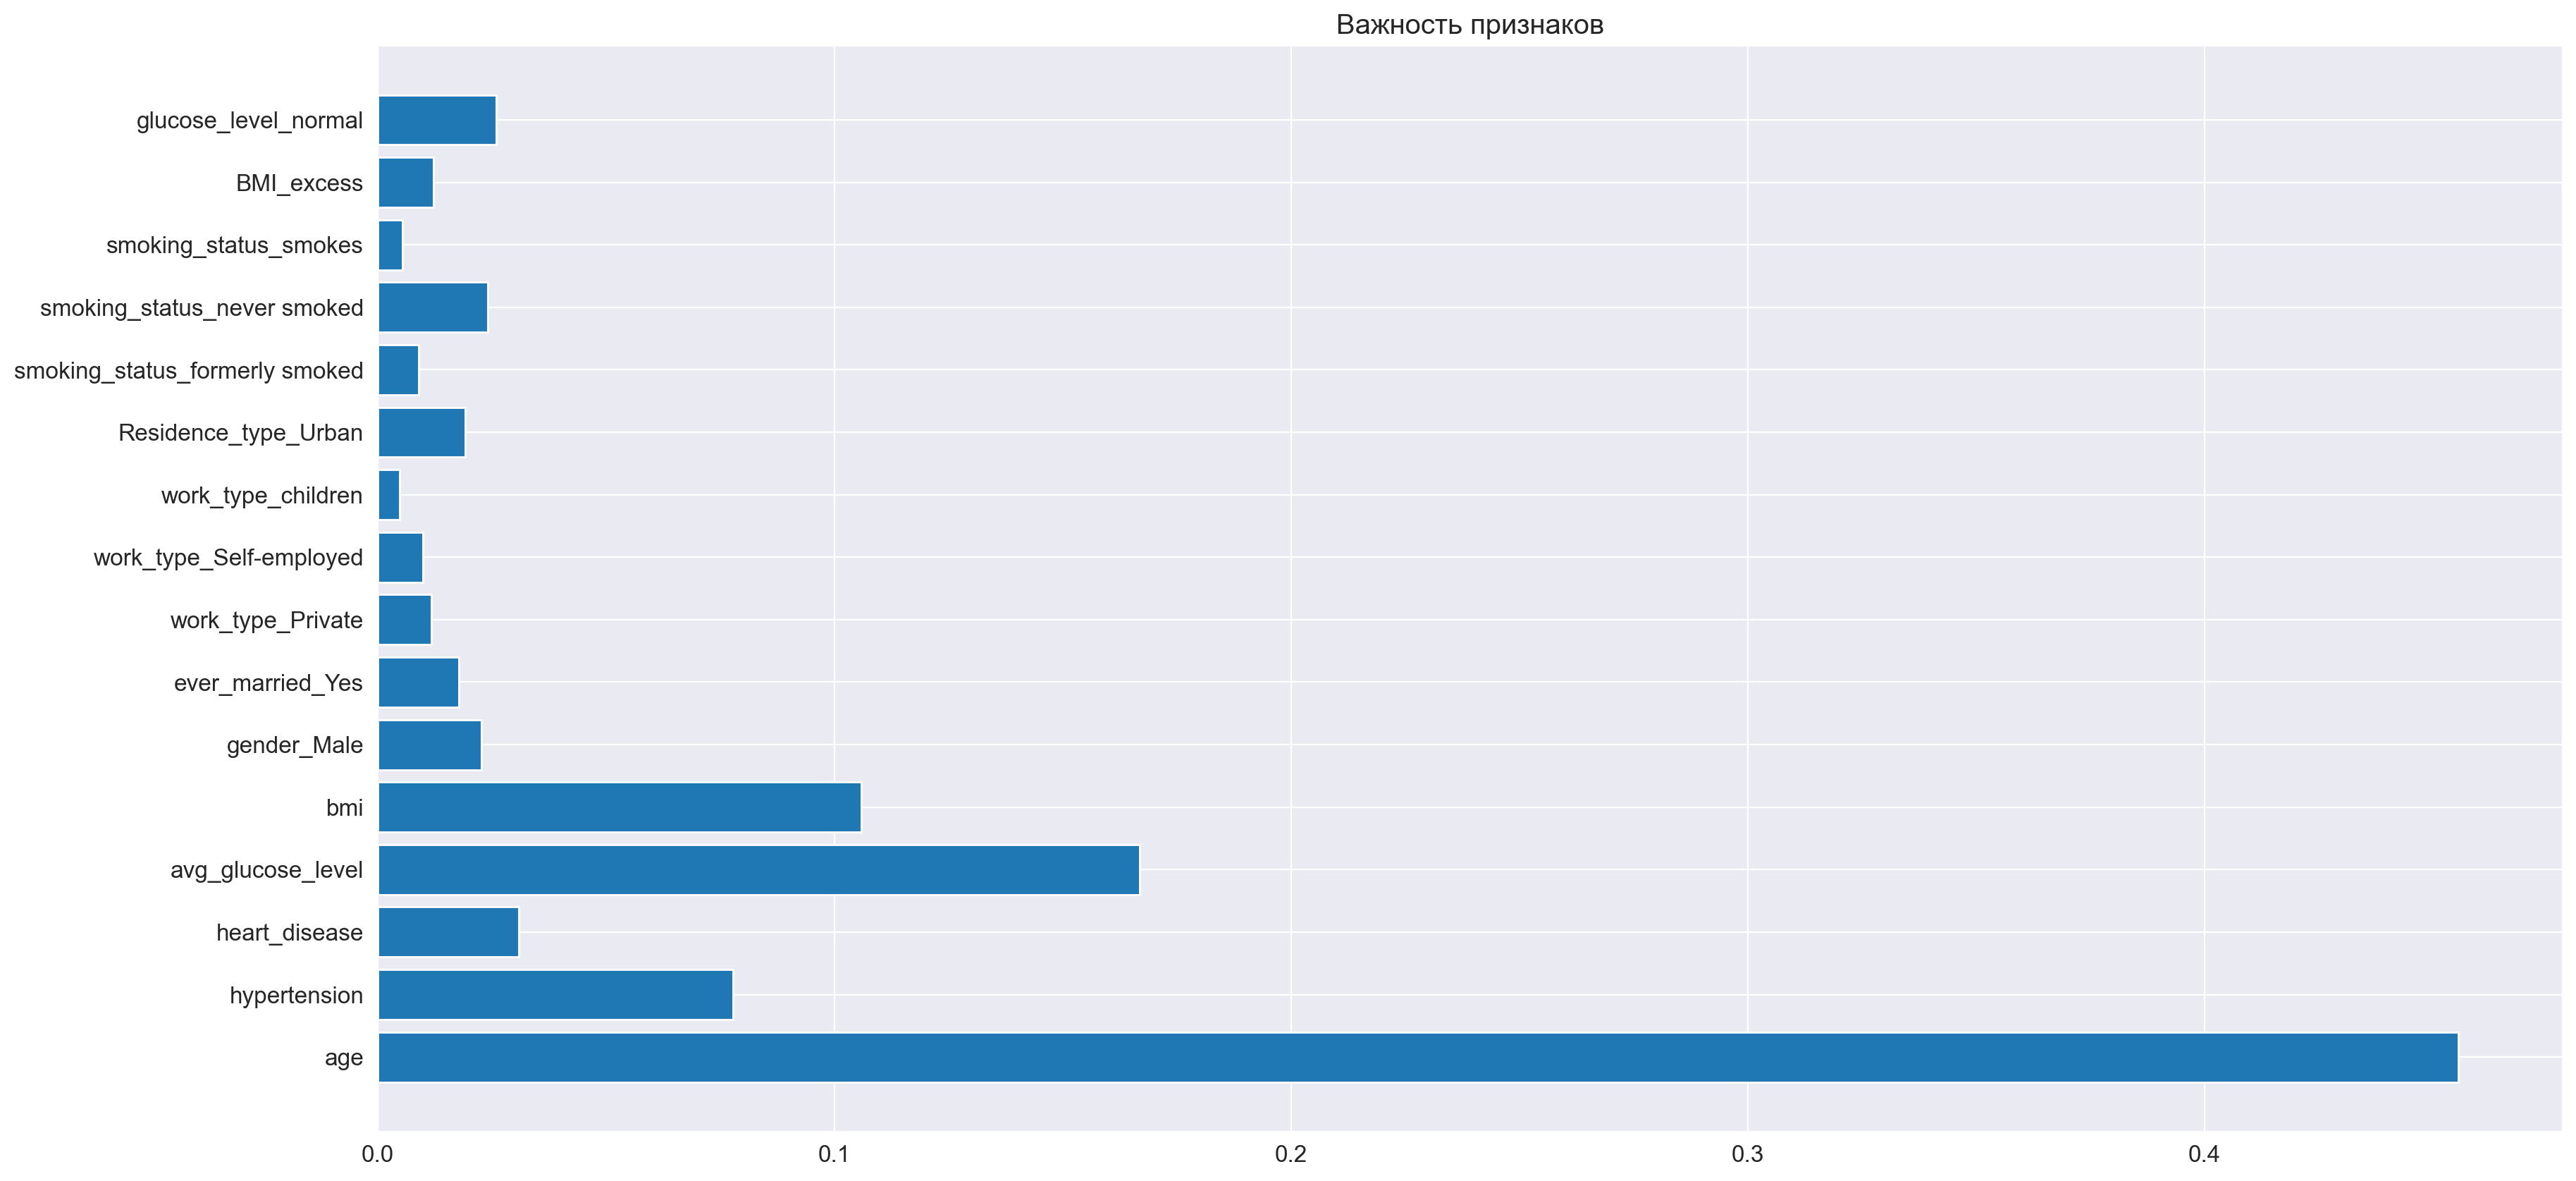

In [249]:
plt.figure(figsize=(20, 10))
plt.title("Важность признаков")
plt.barh(df_train_stroke.drop((target), axis=1).columns, best_model[1].feature_importances_, capsize=1,)
plt.show()

Обучим градиентный бустинг.

Так как в отличие от Random Forest, Gradient boosting - не усредненное моделей, в нем каждая новая модель уточняется предыдущей.(сумма результатов последовательных decision trees для решения новой модели). Используем его, надеясь, что скор улучшится.

In [251]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier().fit(X_train_stroke, y_train_stroke)
print(f"GradientBoosting: roc_auc_score, тестовая выборка: {roc_auc_score(y_test_stroke, model.predict_proba(X_test_stroke)[:, 1])}")

GradientBoosting: roc_auc_score, тестовая выборка: 0.7623707327921717


In [252]:
grid = {
    'n_estimators' : [40, 80, 160],
    'max_depth' : [1, 2, 4, 8],
    'learning_rate' : [0.01, 0.1,1] 
}
best_score = 0.5
best_model = GradientBoostingClassifier()
best_params = {}

for params in tqdm(ParameterGrid(grid)):
    model = make_pipeline(GradientBoostingClassifier(**params)).fit(X_train_stroke, y_train_stroke)
    score = roc_auc_score(y_val_stroke, model.predict_proba(X_val_stroke)[:, 1]) 
    if score > best_score:
        best_score = score
        best_params = params
        best_model = model
print(roc_auc_score(y_test_stroke, model.predict_proba(X_test_stroke)[:, 1]) )
print(best_params)

100%|███████████████████████████████████████████| 36/36 [00:06<00:00,  5.82it/s]

0.7032136105860114
{'learning_rate': 1, 'max_depth': 2, 'n_estimators': 160}


Качество от подбора гиперпараметров значительно увеличивается,если мы смотрим на регрессию или лес, однако бустинг работает хуже. Вероятно, так получается по причине небольшого количества данных.

Лес с подобранными параметрами оказывается лучшим по сравнению с регрессией и бустингом.

----------------------------------------------------------------------------------------------------------------------------------
**Как мы видим ключевым фактором, влияющим что на болезнь сердца, что на инсульт, является возраст.**
Это один из признаков, которые связывают наши датасеты.

Также можно заметить, что модели обучаются примерно с одинаковым качеством. Дата сет про инсульт менее сбалансированный, модель обучается чуть хуже, но при этом в обоих случаях мы видим примерно следующую картину:

**Roc_auc для датасета про болезни сердца увеличивается начиная с:**

1)KNN

2)Boosting

3)Linear Regression

4)Random Forest


Необходимо отметить, что именно подбор параметров помогает нам сильно улучшить скор.


**Roc_auc для датасета про инсульты увеличивается начиная с:**

1)KNN

2)Boosting

3)Random Forest

4)Linear Regression

Такой исход (линейная регрессия обучает 2 датасет лучше, чем лес) возможен из-за маленького количества данных, а следовательно, недостатка деревьев.

-----------------------------------------------------------------------------------------------------------------------------